In [19]:
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

# Define smoothing function
def smooth_and_ci(data, window_size=10):
    smoothed = uniform_filter1d(data, size=window_size, mode='nearest')
    mean = np.mean(smoothed, axis=0)
    std = np.std(smoothed, axis=0)
    return mean, mean - std, mean + std

# Initialize Weights and Biases API
api = wandb.Api()

# Define the project
project = "rabdolla-uuniversity-of-alberta/BASELINE0"
runs = api.runs(project)

# Group runs by their 'group' attribute
groups = {}
for run in runs:
    group_name = run.group or "ungrouped"
    if group_name not in groups:
        groups[group_name] = []
    groups[group_name].append(run)

# Extract environment identifiers from group names
env_groups = {}
for group_name in groups:
    env_name = next((part for part in group_name.split("_") if part.startswith("envsd")), "unknown_env")
    if env_name not in env_groups:
        env_groups[env_name] = []
    env_groups[env_name].append(group_name)

In [20]:
groups['test_noOptions_MiniGrid-FourRooms-v0_gw5_h64_l10_lr0.0005_clip0.15_ent0.05_envsd41']

{'test_noOptions_MiniGrid-FourRooms-v0_gw5_h64_l10_lr0.0005_clip0.15_ent0.05_envsd41': [<Run rabdolla-uuniversity-of-alberta/BASELINE0/25qdqksf (finished)>,
  <Run rabdolla-uuniversity-of-alberta/BASELINE0/2zhyphfx (finished)>,
  <Run rabdolla-uuniversity-of-alberta/BASELINE0/wsyioncy (finished)>,
  <Run rabdolla-uuniversity-of-alberta/BASELINE0/didqh1w4 (finished)>,
  <Run rabdolla-uuniversity-of-alberta/BASELINE0/9fixrd4o (finished)>],
 'test_noOptions_MiniGrid-FourRooms-v0_gw5_h64_l10_lr0.0005_clip0.1_ent0.2_envsd51': [<Run rabdolla-uuniversity-of-alberta/BASELINE0/ty6opibc (finished)>,
  <Run rabdolla-uuniversity-of-alberta/BASELINE0/99n8ynyg (finished)>,
  <Run rabdolla-uuniversity-of-alberta/BASELINE0/gfydr8se (finished)>,
  <Run rabdolla-uuniversity-of-alberta/BASELINE0/suf5hnaq (finished)>,
  <Run rabdolla-uuniversity-of-alberta/BASELINE0/y22wgeru (finished)>],
 'test_decOptionWhole_randomInit_MiniGrid-FourRooms-v0_gw5_h64_l10_lr0.0005_clip0.25_ent0.1_envsd41': [<Run rabdolla-u

Processing environment: envsd41


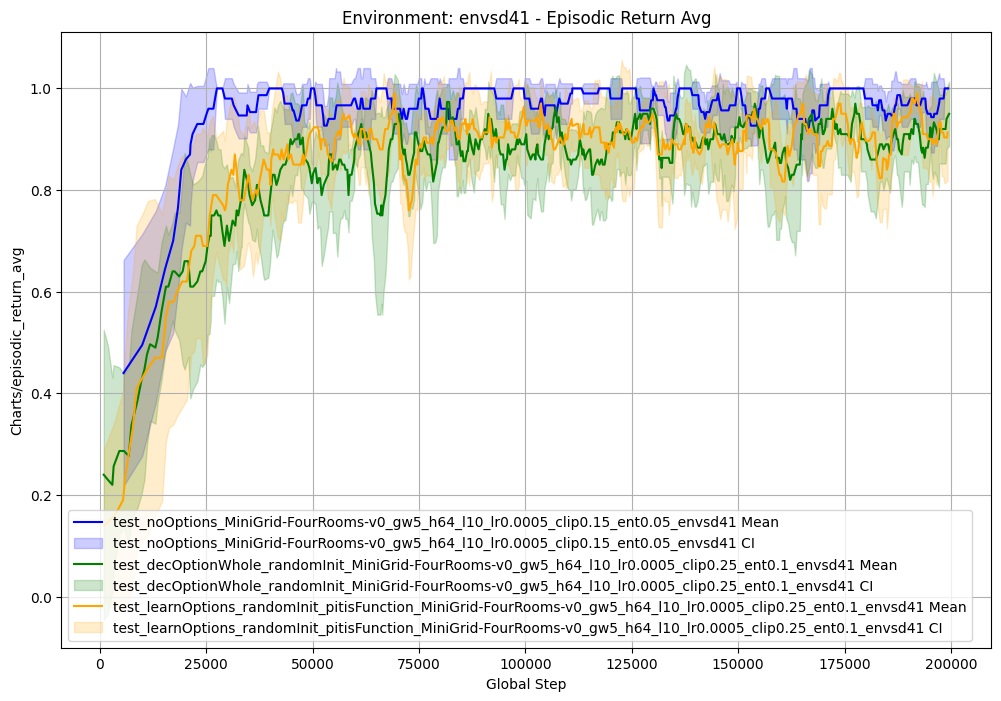

Processing environment: envsd51


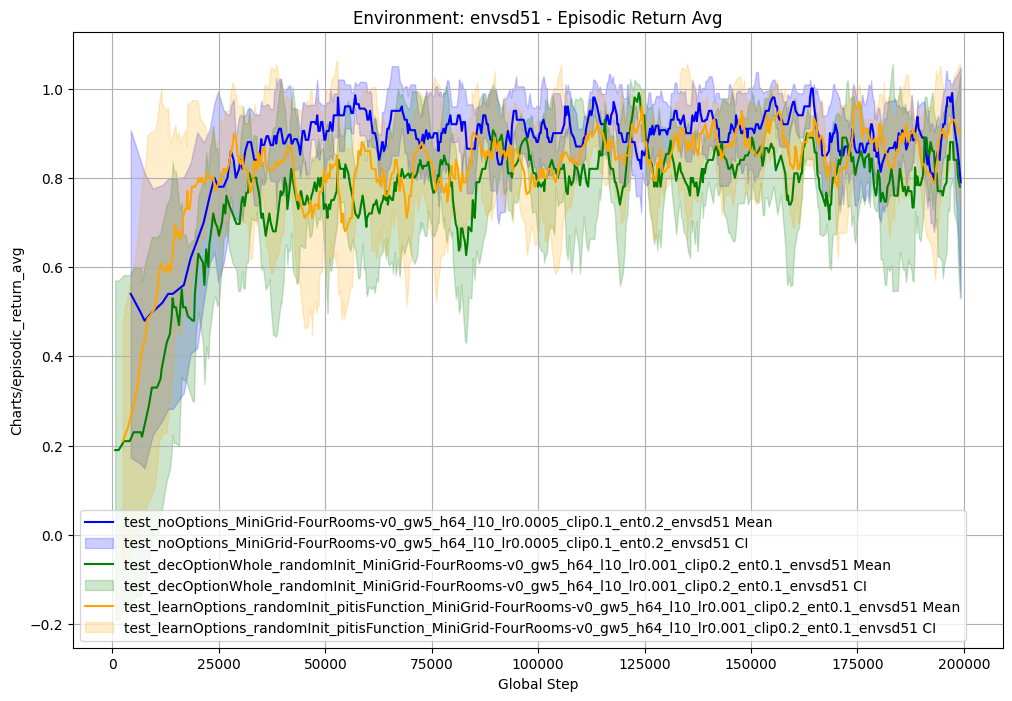

Processing environment: envsd8


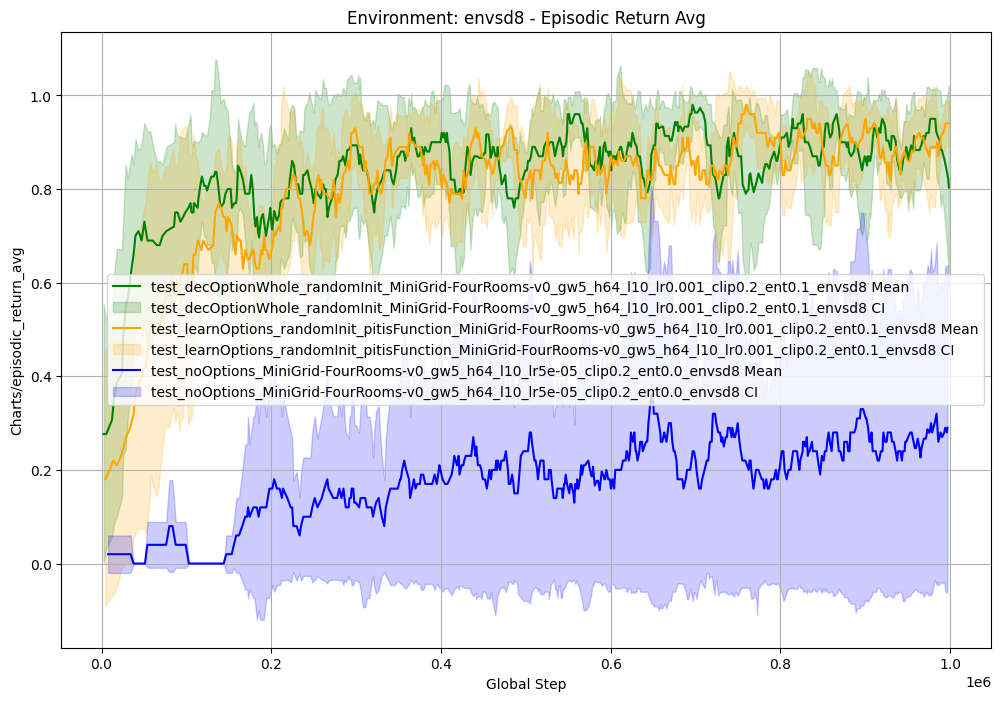

In [24]:
# Define a dictionary for experiment categories and fixed colors
experiment_categories = {
    "test_noOption": "blue",
    "test_decOptionWhole": "green",
    "test_learnOption": "orange",
    "ungrouped": "gray"
}

def get_color(group_name):
    for category, color in experiment_categories.items():
        if category.lower() in group_name.lower():
            return color
    return "black"  # Default color

# Plotting for each environment
def plot_env_groups(env_groups, groups):
    for env_name, group_names in env_groups.items():
        print(f"Processing environment: {env_name}")

        plt.figure(figsize=(12, 8))
        for group_name in group_names:
            group_runs = groups[group_name]

            # Collect data for the metric
            all_data = []
            global_step_values = []
            for run in group_runs:
                try:
                    metric_data = run.history(keys=["Charts/episodic_return_avg", "_step"])
                    if not metric_data.empty:
                        all_data.append(metric_data["Charts/episodic_return_avg"].values)
                        global_step_values.append(metric_data["_step"].values)
                except Exception as e:
                    print(f"Could not fetch data for run {run.id}: {e}")

            # Ensure there is data to process
            if len(all_data) == 0:
                print(f"No data for group {group_name}. Skipping.")
                continue

            # Align lengths of the data
            min_length = min(len(data) for data in all_data)
            aligned_data = [data[:min_length] for data in all_data]
            aligned_global_step = [stem[:min_length] for stem in global_step_values]

            # Smooth data and calculate confidence interval
            mean, lower_ci, upper_ci = smooth_and_ci(np.array(aligned_data), window_size=10)

            # Plot results for the group
            x = np.mean(aligned_global_step, axis=0)  # Use global_step as x-axis
            color = get_color(group_name)
            plt.plot(x, mean, label=f"{group_name} Mean", color=color)
            plt.fill_between(x, lower_ci, upper_ci, color=color, alpha=0.2, label=f"{group_name} CI")

        plt.title(f"Environment: {env_name} - Episodic Return Avg")
        plt.xlabel("Global Step")
        plt.ylabel("Charts/episodic_return_avg")
        plt.legend()
        plt.grid(True)
        plt.show()

plot_env_groups(env_groups, groups)

In [22]:
import wandb
api = wandb.Api()
run = api.run("/rabdolla-uuniversity-of-alberta/BASELINE0/runs/dwruqhk9")

In [23]:
run.history()

,losses/old_approx_kl,Charts/learning_rate,_runtime,_step,Charts/episodic_return_avg,losses/approx_kl,Charts/episodic_length_avg,losses/clipfrac,losses/entropy,losses/value_loss,losses/policy_loss,_timestamp,losses/l1_reg,losses/explained_variance,Charts/SPS
0,NaN,NaN,7.990861,9600,0.0,NaN,100.0,NaN,NaN,NaN,NaN,1.737022e+09,NaN,NaN,NaN
1,NaN,NaN,10.478616,13600,0.0,NaN,100.0,NaN,NaN,NaN,NaN,1.737022e+09,NaN,NaN,NaN
2,0.000986,0.000049,11.896068,15872,NaN,0.000019,NaN,0.0,0.835394,0.002770,-0.001374,1.737022e+09,760.322449,-9.150657,1567.0
3,0.001841,0.000049,13.820852,18944,NaN,0.000237,NaN,0.0,0.824176,0.002319,-0.000944,1.737022e+09,760.412048,-1.858716,1572.0
4,NaN,NaN,17.751773,25200,0.0,NaN,100.0,NaN,NaN,NaN,NaN,1.737022e+09,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,NaN,NaN,676.037412,992552,0.0,NaN,100.0,NaN,NaN,NaN,NaN,1.737023e+09,NaN,NaN,NaN
496,NaN,NaN,677.679478,994940,1.0,NaN,34.0,NaN,NaN,NaN,NaN,1.737023e+09,NaN,NaN,NaN
497,NaN,NaN,677.768299,995032,1.0,NaN,23.0,NaN,NaN,NaN,NaN,1.737023e+09,NaN,NaN,NaN
498,NaN,NaN,679.240039,997224,1.0,NaN,23.0,NaN,NaN,NaN,NaN,1.737023e+09,NaN,NaN,NaN
